Using GPU:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Random seed:  72
    798/1000000 - episode: 1, episode steps: 798, episode reward: 1520.0, max tile: 128
   1610/1000000 - episode: 2, episode steps: 812, episode reward: 896.0, max tile: 64
   2757/1000000 - episode: 3, episode steps: 1147, episode reward: 1168.0, max tile: 128
   2974/1000000 - episode: 4, episode steps: 217, episode reward: 504.0, max tile: 64
   3378/1000000 - episode: 5, episode steps: 404, episode reward: 400.0, max tile: 32
   4019/1000000 - episode: 6, episode steps: 641, episode reward: 1404.0, max tile: 128
   5188/1000000 - episode: 7, episode steps: 1169, episode reward: 1712.0, max tile: 128
   5578/1000000 - episode: 8, episode steps: 390, episode reward: 636.0, max tile: 64
   5851/1000000 - episode: 9, episode steps: 273, episode reward: 740.0, max tile: 64
   6240/1000000 - episode: 10, episode steps: 389, episode reward: 1168.0, max tile: 128
   6892/1000000 - episode: 11, 

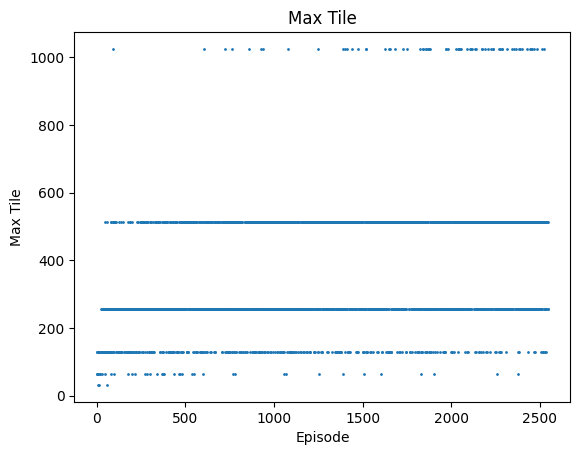

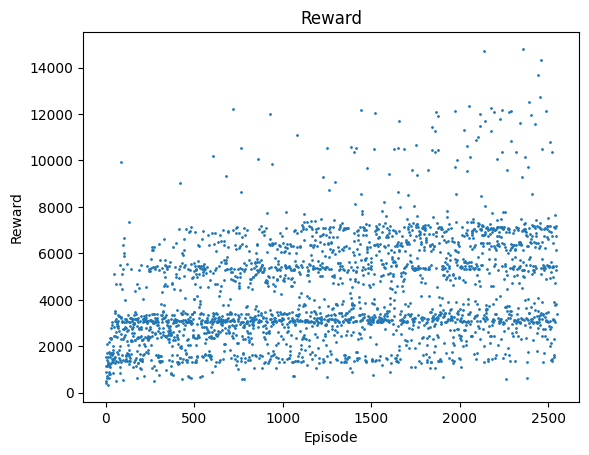

Progress saved at episode 2546


In [12]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
import warnings
import csv

from keras.models import Sequential
from keras.layers import Dense, Flatten
from keras.optimizers import Adam
from rl.agents.dqn import DQNAgent
from rl.policy import EpsGreedyQPolicy, LinearAnnealedPolicy
from rl.memory import SequentialMemory
from rl.callbacks import Callback
from rl.core import Processor
from gym.envs.registration import register
from DQN2048Env import DQN2048Env  

# Create a directory to save files
save_dir = 'DQN'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

csv_path = os.path.join(save_dir, 'training_results.csv')

# Register the custom 2048 environment
register(
    id='DQN2048-v0',
    entry_point='DQN2048Env:DQN2048Env',
)

# Check for available GPUs; use CPU if none are available
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("Using GPU: ", gpus)
    device_name = '/GPU:0'
else:
    print("Using CPU")
    device_name = '/CPU:0'
warnings.filterwarnings('ignore')

# Custom processor for preprocessing game states
class OneHotNNInputProcessor(Processor):
    def __init__(self, num_one_hot_matrices=16, window_length=1, model="dnn"):
        self.num_one_hot_matrices = num_one_hot_matrices  # Maximum one-hot depth
        self.window_length = window_length  # Sliding window size
        self.model = model
        self.game_env = DQN2048Env()  # Instance of 2048 environment
        self.table = {2**i: i for i in range(1, self.num_one_hot_matrices)}  # Map tiles to indices
        self.table[0] = 0  # Map empty tile to 0

    def one_hot_encoding(self, grid):
        """Encode a 2048 grid into a one-hot format."""
        grid_onehot = np.zeros(shape=(self.num_one_hot_matrices, 4, 4))
        for i in range(4):
            for j in range(4):
                grid_element = grid[i, j]
                grid_onehot[self.table.get(grid_element, 0), i, j] = 1
        return grid_onehot

    def get_grids_next_step(self, grid):
        """Generate all possible grids for the next step."""
        grids_list = []
        for movement in range(4):  # Iterate through all possible moves
            grid_before = grid.copy()
            self.game_env.set_board(grid_before)  # Set the current board state
            try:
                _ = self.game_env.move(movement)  # Try to move
            except:
                pass  # Ignore invalid moves
            grid_after = self.game_env.get_board()  # Get the board state after the move
            grids_list.append(grid_after)
        return grids_list

    def process_observation(self, observation):
        """Transform a single observation into the desired input format."""
        observation = np.reshape(observation, (4, 4))  # Reshape into a 4x4 grid
        grids_list_step1 = self.get_grids_next_step(observation)  # First level of moves
        grids_list_step2 = []
        for grid in grids_list_step1:
            grids_list_step2.append(grid)
            grids_temp = self.get_grids_next_step(grid)  # Second level of moves
            for grid_temp in grids_temp:
                grids_list_step2.append(grid_temp)

        grids_list = np.array([self.one_hot_encoding(grid) for grid in grids_list_step2])  # Encode all grids
        return grids_list

    def process_state_batch(self, batch):
        """Process a batch of observations."""
        return batch

# Custom callback to monitor training progress and save state
class Train2048(Callback):
    def __init__(self, dqn, memory, save_dir, csv_path, random_seed, total_nb_steps, save_freq=100, step_save_freq=10000):
        """
        dqn: DQNAgent object, used to save model weights
        memory: Replay memory
        save_dir: Directory to save files
        csv_path: Path to the CSV file recording results for each episode
        random_seed: Random seed used for training
        total_nb_steps: Target total number of training steps set by the user
        save_freq: Frequency (in episodes) to save progress
        step_save_freq: Frequency (in steps) to save progress
        """
        self.dqn = dqn
        self.memory = memory
        self.save_dir = save_dir
        self.csv_path = csv_path
        self.save_freq = save_freq  # Save progress every specified number of episodes
        self.step_save_freq = step_save_freq  # Save progress every specified number of steps

        self.observations = {}
        self.rewards = {}
        self.max_tile = {}
        
        self.step = 0  # Total steps completed (only for complete episodes)
        self.episodes = np.array([])
        self.max_tiles = np.array([])
        self.episodes_rewards = np.array([])

        self.random_seed = random_seed
        self.last_step_save = 0
        self.episode_buffer = []
        self.episode_offset = 0

        self.total_nb_steps = total_nb_steps  # User-set total training steps

    def save_progress(self, episode):
        """Save the model, memory, and training state."""
        # Save model weights
        weight_path = os.path.join(self.save_dir, 'dqn_weights.h5f')
        self.dqn.save_weights(weight_path, overwrite=True)

        # Save memory and training progress
        progress_path = os.path.join(self.save_dir, 'training_progress.pkl')
        progress_data = {
            'episodes': self.episodes,
            'max_tiles': self.max_tiles,
            'episodes_rewards': self.episodes_rewards,
            'current_step': self.step,
            'current_episode': episode,
            'random_seed': self.random_seed,
            'total_nb_steps': self.total_nb_steps  # Keep total steps constant
        }

        with open(progress_path, 'wb') as f:
            pickle.dump({
                'memory': self.memory,
                'progress_data': progress_data
            }, f)

        print(f"Progress saved at episode {episode+1}")

        # Write buffered episode data to CSV
        if self.episode_buffer:
            self.write_buffer_to_csv()
            self.episode_buffer = []

    def write_buffer_to_csv(self):
        """Write buffered episode data to the CSV file."""
        file_exists = os.path.exists(self.csv_path)
        mode = 'a'  # Append mode
        with open(self.csv_path, mode, newline='') as csvfile:
            writer = csv.writer(csvfile)
            # Write header if the file does not exist
            if not file_exists:
                writer.writerow(['episode', 'episode_steps', 'episode_reward', 'max_tile', 'total_step'])
            # Write data for each episode
            for ep_data in self.episode_buffer:
                writer.writerow(ep_data)

    def append_to_buffer(self, episode, episode_steps, episode_reward, max_tile):
        """Append episode results to the buffer."""
        self.episode_buffer.append([episode, episode_steps, episode_reward, max_tile, self.step])

    def on_episode_begin(self, episode, logs):
        """Initialize data structures for a new episode."""
        self.observations[episode] = []
        self.rewards[episode] = []
        self.max_tile[episode] = 0

    def on_episode_end(self, episode, logs):
        """Handle tasks at the end of an episode, including data recording."""
        ep = self.episode_offset + episode + 1
        ep_reward = np.sum(self.rewards[episode])
        ep_steps = len(self.observations[episode])
        ep_max_tile = self.max_tile[episode]

        # Increment global steps only at the end of an episode
        self.step += ep_steps

        self.episodes = np.append(self.episodes, ep)
        self.max_tiles = np.append(self.max_tiles, ep_max_tile)
        self.episodes_rewards = np.append(self.episodes_rewards, ep_reward)

        nb_step_digits = str(int(np.ceil(np.log10(self.total_nb_steps))) + 1)
        template = '{step: ' + nb_step_digits + 'd}/{nb_steps} - episode: {episode}, episode steps: {episode_steps}, episode reward: {episode_reward}, max tile: {max_tile}'
        variables = {
            'step': self.step,
            'nb_steps': self.total_nb_steps,
            'episode': ep,
            'episode_steps': ep_steps,
            'episode_reward': ep_reward,
            'max_tile': ep_max_tile
        }
        print(template.format(**variables))

        # Add data to the buffer
        self.append_to_buffer(ep, ep_steps, ep_reward, ep_max_tile)

        # Clear current episode data
        del self.observations[episode]
        del self.rewards[episode]
        del self.max_tile[episode]

        # Save progress according to the set frequency
        if (ep) % self.save_freq == 0:
            self.save_progress(episode)

    def on_step_end(self, step, logs):
        """Record data at the end of a step, without incrementing global steps."""
        episode = logs['episode']
        self.observations[episode].append(logs['observation'])
        self.rewards[episode].append(logs['reward'])
        self.max_tile[episode] = logs['info'].get('max_tile', 0)

    def on_train_begin(self, logs=None):
        """Actions at the beginning of training."""
        pass  # Random seed was set during initialization

    def on_train_end(self, logs=None):
        """Actions at the end of training, including saving final progress."""
        # Plot maximum tile
        plt.figure()
        plt.scatter(self.episodes, self.max_tiles, s=1)
        plt.title("Max Tile")
        plt.xlabel("Episode")
        plt.ylabel("Max Tile")
        plt.show()

        # Plot rewards
        plt.figure()
        plt.scatter(self.episodes, self.episodes_rewards, s=1)
        plt.title("Reward")
        plt.xlabel("Episode")
        plt.ylabel("Reward")
        plt.show()

        # Save final progress
        if len(self.episodes) > 0:
            self.save_progress(len(self.episodes)-1)

        # Write remaining data in the buffer to the CSV
        self.write_buffer_to_csv()

# Hyperparameters and environment setup
NUM_ACTIONS_OUTPUT_NN = 4  # Number of possible actions
WINDOW_LENGTH = 1
NUM_ONE_HOT_MAT = 16
NB_STEPS_TRAINING = int(1e6)  # Target training steps
NB_STEPS_ANNEALED = int(1e5)  # Annealing steps for the epsilon-greedy strategy
NB_STEPS_WARMUP = 5000  # Warm-up steps before training
MEMORY_SIZE = 6000  # Replay memory size
TARGET_MODEL_UPDATE = 1000  # Frequency for target model updates
LEARNING_RATE = .00025
GAMMA = .99  # Discount factor for future rewards

env = DQN2048Env()  # Initialize the environment

# Check for previously saved training progress
progress_path = os.path.join(save_dir, 'training_progress.pkl')
if os.path.exists(progress_path):
    with open(progress_path, 'rb') as f:
        saved_data = pickle.load(f)
        saved_memory = saved_data['memory']
        saved_progress_data = saved_data['progress_data']

        random_seed = saved_progress_data.get('random_seed', random.randint(0, 100))
        print("Loaded random seed: ", random_seed)

        current_step = saved_progress_data['current_step']
        current_episode = saved_progress_data['current_episode']

        # Calculate remaining training steps
        steps_to_go = NB_STEPS_TRAINING - current_step
        if steps_to_go <= 0:
            print("Training has already completed the target number of steps.")
            steps_to_go = 0
else:
    random_seed = random.randint(0, 100)
    current_step = 0
    steps_to_go = NB_STEPS_TRAINING

print("Random seed: ", random_seed)
random.seed(random_seed)
np.random.seed(random_seed)
env.seed(random_seed)

processor = OneHotNNInputProcessor(num_one_hot_matrices=NUM_ONE_HOT_MAT)

# Define DNN model architecture
INPUT_SHAPE_DNN = (WINDOW_LENGTH, 20, NUM_ONE_HOT_MAT, 4, 4)
with tf.device(device_name):
    model = Sequential()
    model.add(Flatten(input_shape=INPUT_SHAPE_DNN))  # Flatten input
    model.add(Dense(units=1024, activation='relu'))  # First fully connected layer
    model.add(Dense(units=512, activation='relu'))   # Second fully connected layer
    model.add(Dense(units=256, activation='relu'))   # Third fully connected layer
    model.add(Dense(units=NUM_ACTIONS_OUTPUT_NN, activation='linear'))  # Output layer

    # Replay memory
    memory = SequentialMemory(limit=MEMORY_SIZE, window_length=WINDOW_LENGTH)

    # Define training and testing policies
    TRAIN_POLICY = LinearAnnealedPolicy(EpsGreedyQPolicy(), attr='eps', value_max=0.05, value_min=0.05, value_test=0.01, nb_steps=NB_STEPS_ANNEALED)
    TEST_POLICY = EpsGreedyQPolicy(eps=.01)
        
    # Initialize DQN agent
    dqn = DQNAgent(model=model, 
                   nb_actions=NUM_ACTIONS_OUTPUT_NN, 
                   test_policy=TEST_POLICY, 
                   policy=TRAIN_POLICY, 
                   memory=memory, 
                   processor=processor,
                   nb_steps_warmup=NB_STEPS_WARMUP, 
                   gamma=GAMMA, 
                   target_model_update=TARGET_MODEL_UPDATE, 
                   train_interval=4, 
                   delta_clip=1.)
    dqn.compile(Adam(learning_rate=LEARNING_RATE), metrics=['mse'])

    # Initialize training callback and pass random_seed and total training steps
    train_2048 = Train2048(dqn, memory, save_dir=save_dir, csv_path=csv_path, random_seed=random_seed, total_nb_steps=NB_STEPS_TRAINING, save_freq=100, step_save_freq=10000)
    _callbacks = [train_2048]

    # Load previous training progress if available
    if os.path.exists(progress_path):
        with open(progress_path, 'rb') as f:
            saved_data = pickle.load(f)
            saved_memory = saved_data['memory']
            saved_progress_data = saved_data['progress_data']

            # Restore memory
            dqn.memory = saved_memory
            print("Loaded saved memory.")

            # Restore progress data
            train_2048.episodes = saved_progress_data['episodes']
            train_2048.max_tiles = saved_progress_data['max_tiles']
            train_2048.episodes_rewards = saved_progress_data['episodes_rewards']
            train_2048.step = saved_progress_data['current_step']

            train_2048.episode_offset = saved_progress_data['current_episode'] + 1
            print(f"Loaded current_episode: {saved_progress_data['current_episode']+1}, next episode will start from {train_2048.episode_offset+1}")

    # Load weights
    weight_path = os.path.join(save_dir, 'dqn_weights.h5f')
    if os.path.exists(weight_path):
        dqn.load_weights(weight_path)
        print("Loaded saved weights.")

    # Continue training from where it was interrupted
    if steps_to_go > 0:
        dqn.fit(env, callbacks=_callbacks, nb_steps=steps_to_go, visualize=False, verbose=0)
    else:
        print("No further training needed.")
